# Likelihood evolution: Gaussian noise and averages

Adapted from Sivia: *Data Analysis: A Bayesian Tutorial*

Here we'll take a look at a simple parameter-estimation problem. We will compare the frequentist and Bayesian approaches. This problem is an extended version of Example 2 in Ch 2.3 of the book by Sivia. This short book is very readable and is highly recommended.

This notebook was adapted from a broad introduction to Bayesian statistics put together by Christian Forssen for the 2019 TALENT school on ["Learning from Data"](https://nucleartalent.github.io/Bayes2019/).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Not really needed, but nicer plots
import seaborn as sns
sns.set()      
sns.set_context("talk")

In [2]:
# Modules needed for example: emcee is for MCMCsampling, corner for plotting
from scipy import stats
import emcee
import corner

Let us consider the problem of estimating the mean and the variance of a normal distribution that is associated with a collection of random variables. The normal distribution
$$
p(x|\mu,\sigma) = \frac{1}{\sqrt{2\pi}\sigma} \exp \left(-\frac{(x-\mu)^2}{2\sigma^2} \right),
$$
is often used as a theoretical model to describe the noise associated with experimental data.

*Why is a normal (Gaussian) distribution so often a good statistical model?* 


Let us assume that we have a series of $M$ measurements $D \equiv \{ x_k \} = (x_1, \ldots, x_M)$, that are samples from a normal $\mathcal{N}(\mu, \sigma^2)$ population, from which we would like to learn the approximate values of the parameters $\mu$ and $\sigma$. The standard frequentist approach to this problem is the maximum likelihood method. The Bayesian approach is to compute the posterior distribution for the model parameters $\mu$ and $\sigma$.

Here we'll use Python to generate some toy data to demonstrate the two approaches to the problem. 

In [58]:
# Generating some data
ran_seed = None
np.random.seed(ran_seed)  # for repeatability

mu_true = 10   # true peak position 
sigma_true = 1 # true standard deviation 
M = 100 # number of measurements
D = stats.norm.rvs(mu_true, sigma_true, size=M)  # M measurements (samples)

### Frequentist approach to Gaussian parameter estimation

We'll start with the classical frequentist **maximum likelihood** approach. The probability of a single measurement $D_i$ having a value $x_i$ is given by 

$$ p(x_i~|~\mu, \sigma) = \frac{1}{\sqrt{2\pi \sigma^2}} \exp{\left[\frac{-(x_i - \mu)^2}{2 \sigma^2}\right]}, $$

where $\mu$, $\sigma$ are the *true* values for the model parameters.

We construct the **likelihood function** by computing the product of the probabilities for each data point:

$$\mathcal{L}(D~|~\mu, \sigma) = \prod_{i=1}^M p(x_i~|~\mu, \sigma)$$




Because the value of the likelihood can become very small, it is often more convenient to instead compute the log-likelihood. Furthermore, when we are looking for the maximum of the likelihood, we might just as well maximize the log-likelihood. Combining the previous two equations and computing the log, we have

$$\log\mathcal{L} = -\frac{1}{2} \sum_{i=1}^M \left[ \log(2\pi  \sigma^2) + \frac{(x_i - \mu)^2}{\sigma^2} \right]$$

What we'd like to do is find $\mu_0,\sigma_0$ such that the likelihood (or log likelihood) is maximized. For this simple problem, the maximization can be computed analytically (i.e. by setting $\left. \partial\log\mathcal{L}/\partial\mu \right|_{\mu_0,\sigma_0} = \left. \partial\log\mathcal{L}/\partial\sigma \right|_{\mu_0,\sigma_0} = 0$).  This results in the following *maximum-likelihood estimates* of the true parameters:

$$ 
\mu_0 = \frac{1}{M}\sum_{i=1}^M x_i \\
\sigma_0^2 = \frac{1}{M}\sum_{i=1}^M (x_i - \mu_0)^2
$$

In principle, we should also compute the second derivatives to make sure that this point represents a maximum rather than a minimum or a saddle point. However, in agreement with intuition, $\mu_0$ is simply the mean of the observed data. These results are fairly simple calculations; let's evaluate them for our toy dataset:

In [59]:
def log_likelihood(mu, y_pts, sigma_true):
    return -0.5 * np.sum( np.log(2 * np.pi * sigma_true**2) \
                  + (y_pts - mu)**2 / sigma_true**2 )

In [91]:
def plot_likelihoods(index, D, mu_min, mu_max, num_mu=20):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,5))

    axes[0].scatter(np.arange(index+1)+1, D[0:index+1], alpha=0.5, color="blue")
    axes[0].hlines([mu_true], 0, num_mu, color='black', alpha=0.2)
    axes[0].set_xlim(0, num_mu)
    axes[0].set_ylim(mu_min, mu_max)
    axes[0].set_ylabel(r"$\mu$")
    axes[0].set_xlabel("measurement number")
    string = fr'$N = {index+1}$'
    axes[0].text(0.7*num_mu, mu_min+.8*(mu_max-mu_min), string)

    axes[1].set_xlabel(r"$\mu$")
    axes[1].set_xlim(mu_min, mu_max)
    
    likelihood_pts = np.array([np.exp(log_likelihood(mu, D[0:index], sigma_true)) for mu in mu_pts])
    axes[1].plot(mu_pts, likelihood_pts/likelihood_pts.max(), 
                 label=r'old $\mathcal{L}$', color='blue')

    likelihood_pts = np.array([np.exp(log_likelihood(mu, D[index], sigma_true)) for mu in mu_pts])
    axes[1].plot(mu_pts, likelihood_pts/likelihood_pts.max(), 
                 label=r'added $\mathcal{L}$', color='black', alpha=0.5)
    
    likelihood_pts = np.array([np.exp(log_likelihood(mu, D[0:index+1], sigma_true)) for mu in mu_pts])
    axes[1].plot(mu_pts, likelihood_pts/likelihood_pts.max(), 
                 label=r'updated $\mathcal{L}$', color='red')
    
    axes[1].legend()
    
    fig.tight_layout()
    return 0


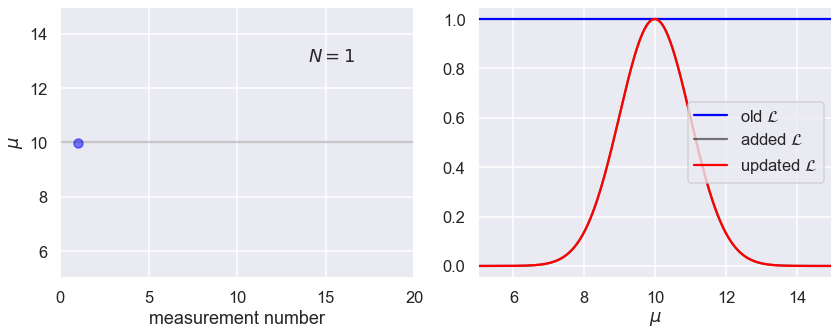

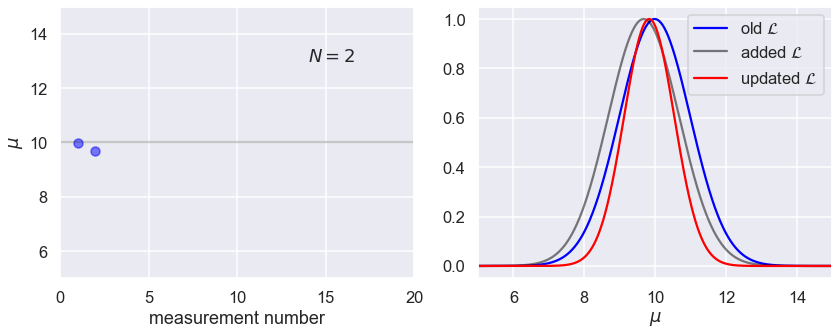

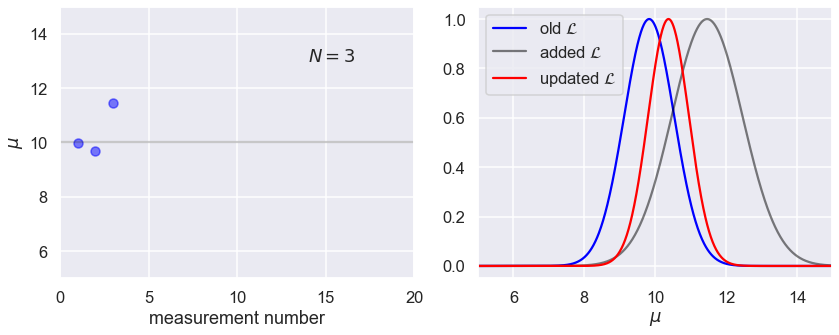

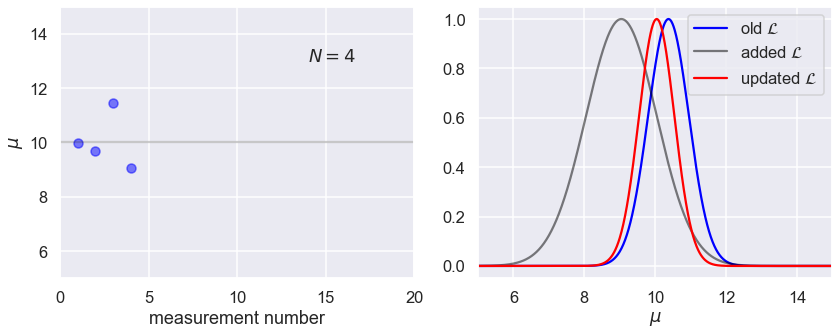

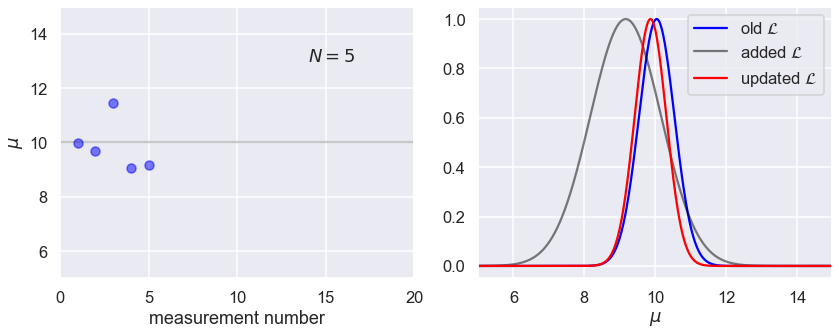

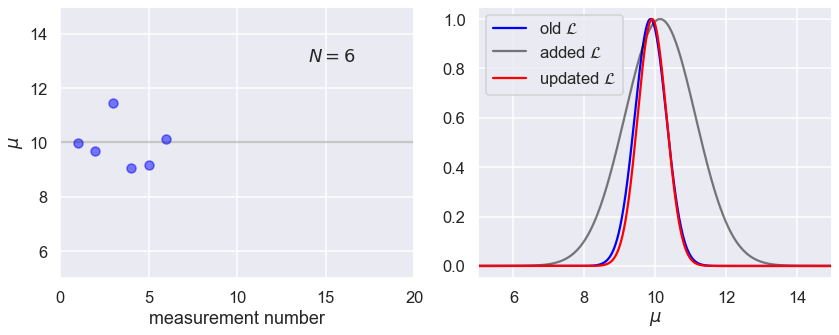

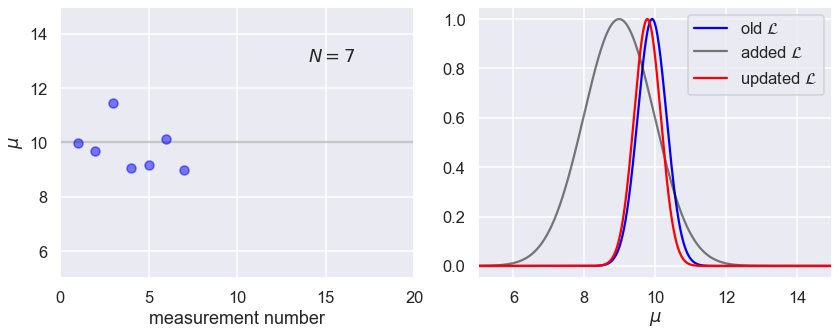

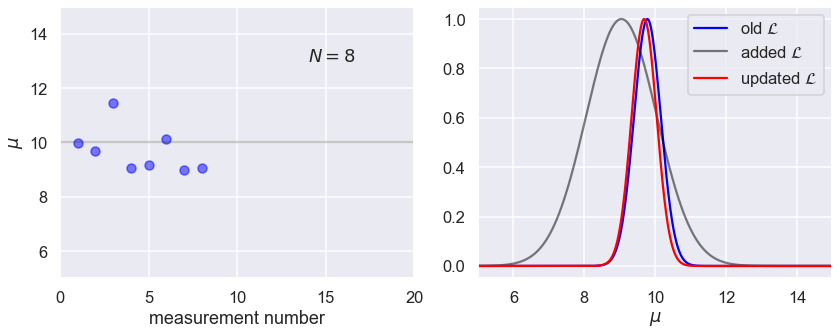

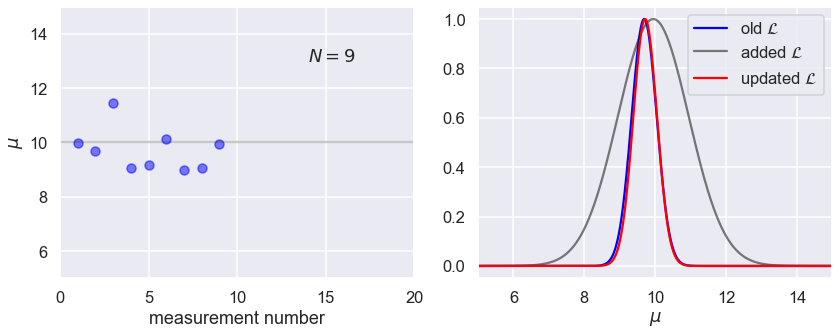

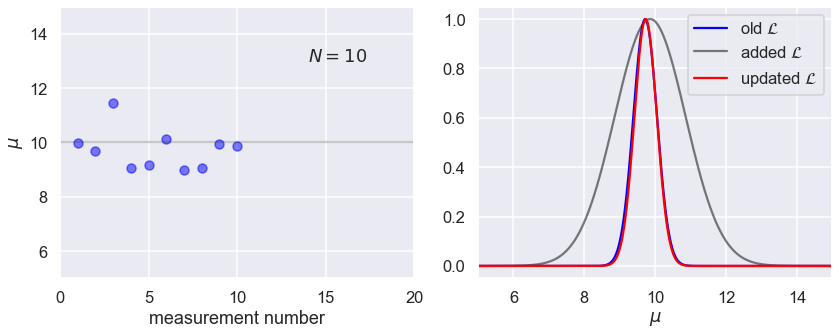

In [92]:
mu_pts = np.arange(0, 20, .01)
mu_min = 5
mu_max = 15
num_mu = 20

index = 10
for i in range(index):
    plot_likelihoods(i, D, mu_min, mu_max, num_mu)